In [1]:
# Python imports
import sys, numpy as np
# Torch
import torch, torchvision, torch.nn as nn, torch.optim as optim
# Navigation MDP
import navigation_mdp as NvMDP
# RL utils
import rl.planning as Plan
import rl.policy as Policy
from rl.model import RewardLinear, RewardConvFCAE
# Utils
from utils.utils import *
from utils.plotting import NavGridViewPlotter as NvPlotter, plot_grid_data_helper
# Matplotlib
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

## Gridworld 5x7 image features

In [2]:
cifar = torchvision.datasets.CIFAR100(root="../datasets/", download=True)
X, y = cifar.data, np.asarray(cifar.targets)
classes = np.unique(y)
n_classes = len(classes)

print(X.shape, y.shape)

Files already downloaded and verified
(50000, 32, 32, 3) (50000,)


In [3]:
print(cifar.classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [4]:
cifar.classes.index("sunflower")

82

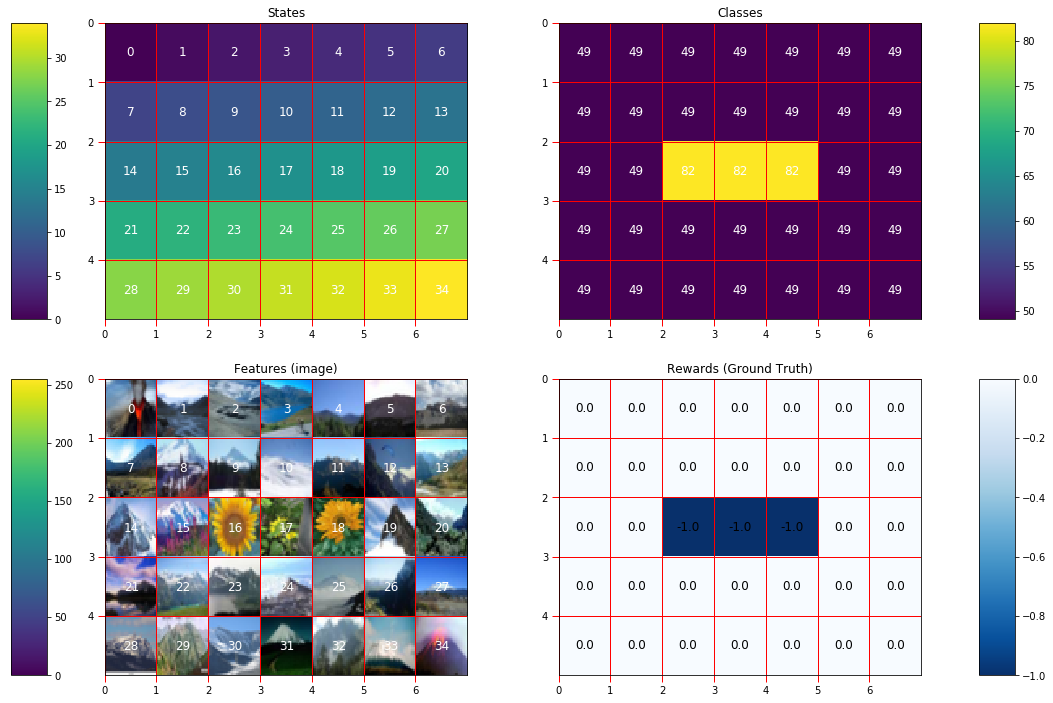

In [5]:
np.random.seed(1)
# Specify state space
S = NvMDP.state.DiscreteStateSpace(5,7)
goal_loc = (2,6)
# Attach classes
class_ids = NvMDP.class_.XYClassDistribution([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], 
    marker_to_class_id = {0: 49, 1: 82})().flatten()
S.attach_classes(class_ids)
# Attach features
S.attach_features(NvMDP.features.FeatureClassImageSampler(S, lambda x: sample_image(X, y, x)))
# Attach rewards
S.attach_rewards(NvMDP.reward.RewardStateScalar(S, 
                    loc_to_reward_dict={goal_loc: 0.}, class_id_to_reward_dict={82: -1}, default=0))
R = S.rewards()
# Specify dynamics
T = NvMDP.dynamics.XYDynamics(S, slip_prob=0.)

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(2,2,3)
NvPlotter(S).plot_features(
    ann=S.idxs.flatten(), cmap=cm.viridis, ann_col="white", 
    title="Features (image)").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,4)
NvPlotter(S).plot_rewards(
    cmap=cm.Blues_r, title="Rewards (Ground Truth)").colorbar(where="right", pad=0.8, size="10%").grid()

RewardConvFCAE(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (sigmoid): Sigmoid()
  (fc_reward): Linear(in_features=64, out_features=1, bias=False)
  (t_fc2): Linear(in_features=64, out_features=128, bias=True)
  (t_fc1): Linear(in_features=128, out_features=1024, bias=True)
  (t_conv2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv1): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


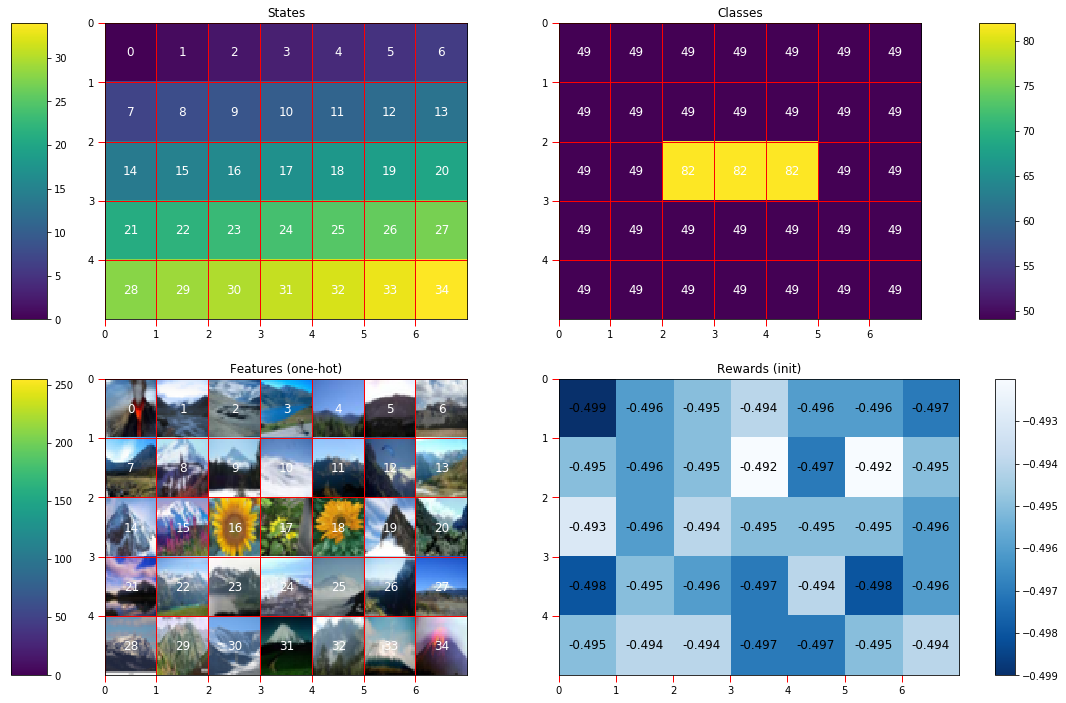

In [6]:
PHI = torch.FloatTensor(S.features()).permute(0,3,1,2) / 255.
R_model = RewardConvFCAE(PHI[0].shape, fc1_in=1024, lr=0.001, weight_decay=0.)
print(R_model)

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(2,2,3)
NvPlotter(S).plot_features(
    ann=S.idxs.flatten(), cmap=cm.viridis, ann_col="white", 
    title="Features (one-hot)").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,4)
NvPlotter(S).plot_array(R_model(PHI)[0].detach().numpy().round(3), 
                           cmap=cm.Blues_r, title="Rewards (init)").colorbar(where="right", pad=0.5)

In [7]:
# # T.ACTIONS: ['U', 'D', 'L', 'R']
# Sk = S.at_loc((2,2))
# Ak = "U"
goal = S.at_loc((2,6))
log_likelihoods_history = []
tau_s_list = [[(2,0), (2,1), (1,1), (1,2), (1,3), (1,4), (1,5), (2,5), (2,6)], 
            [(2,0), (2,1), (3,1), (3,2), (3,3), (3,4), (3,5), (2,5), (2,6)]]
tau_a_list = [["R", "U", "R", "R", "R", "R", "D", "R"],
              ["R", "D", "R", "R", "R", "R", "U", "R"]]

for _iter in range(150):
    
    _iter_start_time = time.time()
    R_model.zero_grad()
    VI = Plan.ValueIteration(S, R_model(PHI)[0], T, verbose=True, log_pi=False, gamma=0.99, goal=goal)
    VI.run(100, lambda q: Policy.Boltzmann(q, boltzmann_temp=.1), reasoning_iters=100, 
           verbose=True, debug=False, eps=1e-6)
    
    for k in range(len(tau_s_list)):
        loss = 0
        for i in range(len(tau_a_list)):
            loss += -torch.log(VI.Pi[VI.get_tbl_idxs(S.at_loc(tau_s_list[k][i]), tau_a_list[k][i])])
    #         print(Pi[VI.get_tbl_idxs(S.at_loc((2,1+i)), "R")], loss)
    ll = np.exp(-loss.detach().item())
    log_likelihoods_history.append(ll)
    
    print("\n>>> Iter: {:04d} ({:03.3f}s): loss = {:09.6f}, likelihood = {:02.4f}\n\n".format(
                    _iter, time.time()-_iter_start_time, loss, ll))
    loss.backward()
    R_model.step()

Setting goal as terminal state!
Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0000 (1.782s): loss = 09.397044, likelihood = 0.0001


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0001 (1.840s): loss = 08.208211, likelihood = 0.0003


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0002 (1.685s): loss = 06.894595, likelihood = 0.0010


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0003 (1.702s): loss = 05.289259, likelihood = 0.0050


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0004 (1.726s): loss = 03.398054, likelihood = 0.0334


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0005 (1.725s): loss = 02.141741, likelihood = 0.1175


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0006 (1.717s): loss = 01.977038, likelihood = 0.1385


Learning values [  ] St


>>> Iter: 0060 (1.740s): loss = 00.016261, likelihood = 0.9839


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0061 (1.769s): loss = 00.016140, likelihood = 0.9840


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0062 (1.732s): loss = 00.015899, likelihood = 0.9842


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0063 (1.837s): loss = 00.015534, likelihood = 0.9846


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0064 (1.780s): loss = 00.015061, likelihood = 0.9851


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0065 (1.711s): loss = 00.014502, likelihood = 0.9856


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0066 (1.817s): loss = 00.013889, likelihood = 0.9862


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0067 (1.980s): loss = 00.013252, likelihood 

Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0121 (1.756s): loss = 00.006535, likelihood = 0.9935


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0122 (1.721s): loss = 00.006490, likelihood = 0.9935


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0123 (1.714s): loss = 00.006444, likelihood = 0.9936


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0124 (1.838s): loss = 00.006399, likelihood = 0.9936


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0125 (1.753s): loss = 00.006354, likelihood = 0.9937


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0126 (1.773s): loss = 00.006309, likelihood = 0.9937


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0127 (1.690s): loss = 00.006265, likelihood = 0.9938


Learning values [  ] Stopped @ 0.
Reasoning [  0 30 60 90 99 ] Done.

>>> Iter: 0128 (1.6

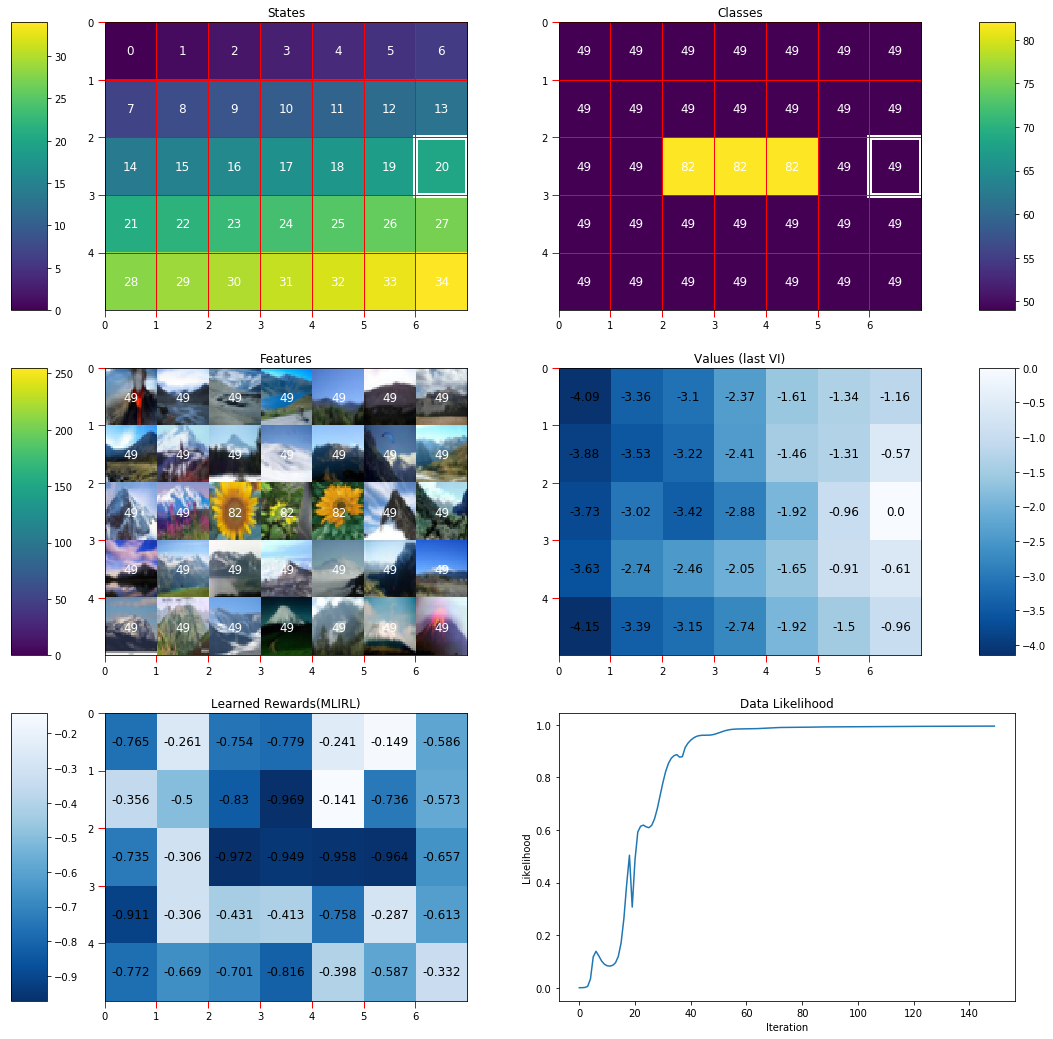

In [8]:
plt.figure(figsize=(18,18))
plt.subplot(3,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(3,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(3,2,3)
NvPlotter(S).plot_features(
    ann_col="white", cmap=cm.viridis).colorbar(where="left", pad=.8, size="10%")
plt.subplot(3,2,4)
NvPlotter(S).plot_array(VI.V.detach().numpy().round(2),
                           cmap=cm.Blues_r, title="Values (last VI)").colorbar(where="right", pad=0.8, size="10%")
plt.subplot(3,2,5)
NvPlotter(S).plot_array(R_model(PHI)[0].detach().numpy().round(3), 
                           cmap=cm.Blues_r, title="Learned Rewards(MLIRL)").colorbar(where="left", pad=0.8, size="10%")
plt.subplot(3,2,6)
plt.plot(range(len(log_likelihoods_history)), log_likelihoods_history)
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.title("Data Likelihood")
plt.savefig("./figures/mlirl_gw_5x7_cifar100_images__traj_2_turns")

**Problems:**
Doesn't always work. Finds and gets stuck on a degenerate solution (R = 0 everywhere).